In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


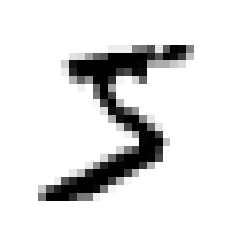

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

## Train - Test split

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [9]:
y_train_5.dtype

dtype('bool')

## Training a Binary Classifier

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
sgd_clf.predict([X[4]])

array([False])

## Performance Measure

k-Fold Cross Validation Score on each fold:

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.96466961, 0.957     , 0.95516667, 0.95733333, 0.96733061])

Just like the <code>cross_val_score()</code> function, <code>cross_val_predict()</code> performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53677,   902],
       [ 1480,  3941]], dtype=int64)

       Predict 5  Predict not 5
5           3941           1480
Not 5        902          53677


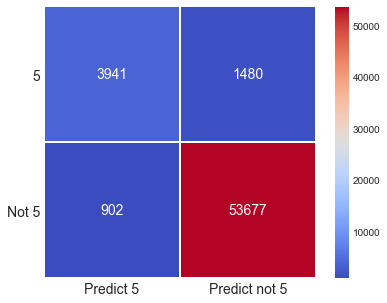

In [17]:
from sklearn import metrics

cm=metrics.confusion_matrix(y_train_5, y_train_pred, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["5","Not 5"]],
                  columns = [i for i in ["Predict 5","Predict not 5"]])
print(df_cm)

plt.figure(figsize = (7,5))
g = sns.heatmap(df_cm, annot=True, cmap = 'coolwarm', fmt='g', square=True, linewidth=1, annot_kws={"size":14})
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize = 14)
g.set_xticklabels(g.get_xticklabels(), horizontalalignment='center', fontsize = 14)
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### Precision, Recall and Decision Function Score

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_train_5, y_train_pred)
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f'SGDClassifier Accuracy: {accuracy}')
print(f'SGDClassifier Precision: {precision}')
print(f'SGDClassifier Recall: {recall}')
print(f'SGDClassifier f1 - score: {f1}')

SGDClassifier Accuracy: 0.9603
SGDClassifier Precision: 0.8137518067313648
SGDClassifier Recall: 0.7269876406567054
SGDClassifier f1 - score: 0.7679267342166797


Let’s look at how the <code>SGDClassifier</code> makes its classification
decisions. For each instance, it computes a score based on a <i>decision function</i>,
and if that score is greater than a threshold, it assigns the instance to the positive
class, or else it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
<code>predict()</code>method, you can call its <code>decision_function()</code> method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:

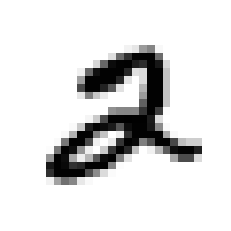

In [19]:
some_digit = X[5]

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [21]:
# Check the label:
y[5]

2

In [22]:
# For this entry, our classifier is correct in its prediction:
sgd_clf.predict([X[5]])

array([False])

In [23]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([-3908.27576291])

In [25]:
some_digit = X[0]
print(sgd_clf.predict([X[0]]))
y_score = sgd_clf.decision_function([some_digit])
y_score

[ True]


array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 5000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the <code>cross_val_predict()</code> function
again, but this time specifying that you want it to return decision scores instead of
predictions:

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores you can compute precision and recall for all possible thresholds
using the <code>precision_recall_curve()</code> function:

In [32]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

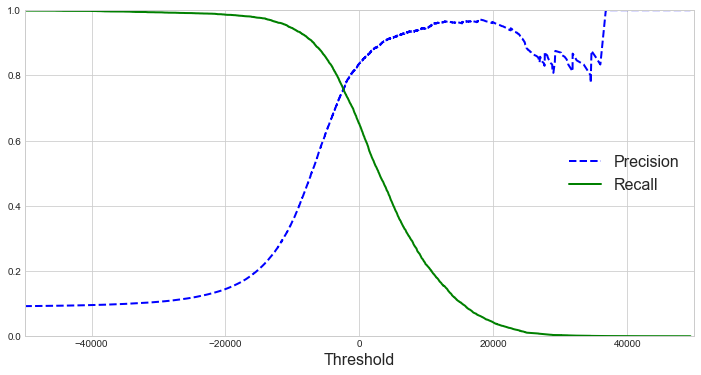

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(12, 6))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

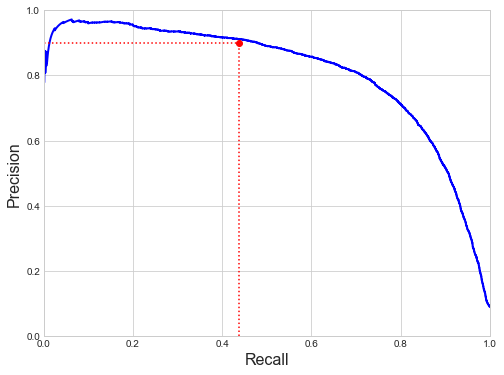

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")

plt.show()

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

To make predictions (on the training set for now), instead of calling the classifier’s
<code>predict()</code> method, you can just run this code:

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

The Receiver Operating Characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold
values, using the <code>roc_curve()</code> function:

In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

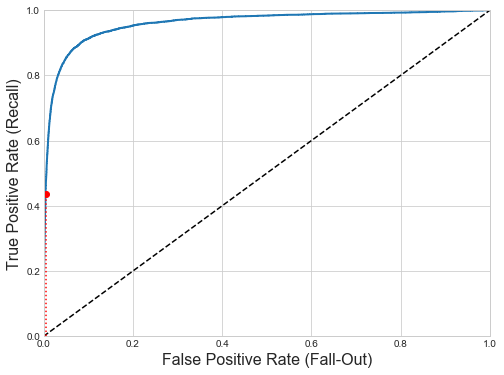

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

plt.show()

ne way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [45]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=30, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [47]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

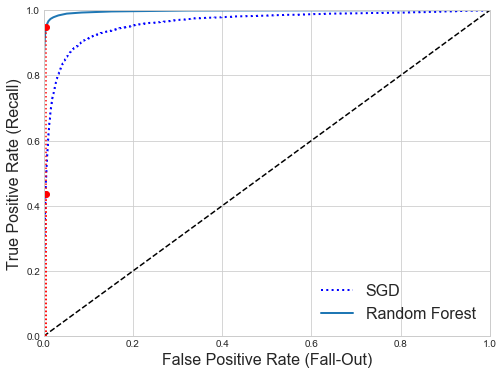

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()